In [3]:
import os
import re
import json
import codecs
import locale
import requests
import datetime

import tabula

from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import pandas as pd
locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')


'it_IT.UTF-8'

In [4]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

# Population data.
regions_data_file_path = os.path.join("..","data", "Istat", "Tavole-Bilancio-demografico-2018.xlsx")

# Place where images are saved:
images_path = os.path.join("..","images")
image_prefix = ""

# Url of the pdf file to download:
url_region_pdf = "http://www.salute.gov.it/imgs/C_17_notizie_4829_0_file.pdf"
pdf_file_name = os.path.join(os.sep, "tmp", "temp_data_file.pdf")


In [5]:
regions_df = pd.read_excel(regions_data_file_path, sheet_name=0)
regions_df.drop(regions_df.index[:5], inplace=True)
regions_df.drop(regions_df.index[regions_df.shape[0] - 2:regions_df.shape[0]], inplace=True)
regions_df.rename(columns={regions_df.columns[0]: "Regione"
                          ,regions_df.columns[1]: "Popolazione"}
                 ,inplace = True)
regions_df = regions_df.loc[:,["Regione","Popolazione"]]
regions_df["Popolazione"] = pd.to_numeric(regions_df['Popolazione'])
regions_df.sort_values(by=["Regione"], inplace=True)

popolazione_it = regions_df.loc[regions_df["Regione"] == "Italia", "Popolazione"].values[0]

(regions_df.shape,regions_df.dtypes)

((28, 2),
 Regione        object
 Popolazione     int64
 dtype: object)

In [6]:
regions_df.head(3)

,Regione,Popolazione
19,Abruzzo,1315196
23,Basilicata,567118
9,Bolzano-Bozen,527750


In [7]:
# ------------------------------------------------------------
# ------------------------------------------------------------
# Some common functions.
# ------------------------------------------------------------
# ------------------------------------------------------------
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0, fontsize=8):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom'
               ,fontsize=fontsize)
        
def set_axes_common_properties(axe, no_grid=False, border=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(border)
        axe.spines['left'].set_visible(border)
        axe.spines['right'].set_visible(border)
        axe.spines['bottom'].set_visible(border)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

def text_box(ax, text, colors=["#FFFFFF", "#000000"], fontsize=14, x=0, y=0):
    """
    """
    rv = False
    try:
        edgecolor = "none"
        boxstyle = "square"
        if len(colors) >= 3 and colors[2] is not None:
            edgecolor = colors[2]
            boxstyle = "round,pad=1"
        ax.text(x, y
               ,text
               ,ha="left", va="center" 
               ,bbox=dict(boxstyle = boxstyle, facecolor = colors[0], edgecolor = edgecolor)
               ,color=colors[1]
               ,fontsize=fontsize)
        set_axes_common_properties(ax, no_grid=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    except Exception as ex:
        print("text_box failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv   

#----------------------------------------------------------------
#
#----------------------------------------------------------------

def get_web_file(url):
    """
    
    :param url: 
    :return (rv, content):
    """
    ok_statuses = [200, 201, 202]
    rv = False
    result = None
    try:
        result = requests.get(url_region_pdf)
        if result.status_code not in ok_statuses:
            print("Get data failed. Received error code: {er}".format(er=str(result.status_code)))
        else:
            result = result.content
    except Exception as ex:
        print("get_web_file failed - {ex}".format(ex=ex))
    else:
        rv = True
    return (rv, result)    
        
def save_content_to_file(file_name, content):
    """
    
    :param file_name: 
    :return rv:
    """
    rv = False
    try:
        with open(file_name, "wb") as fh:
            fh.write(content)
    except Exception as ex:
        print("save_content_to_file failed - {ex}".format(ex=ex))
    else:
        rv = True
    return rv
   
def pdf_to_dataframe(pdf_file_name, version = "v2"):
    """
    
    :param version: valid values v1 or v2; 
    :param pdf_file_name: 
    :return rv:
    """
    rv = False
    df = None
    try:
        df = tabula.read_pdf(pdf_file_name, pages='all')
        #print("Df list len: {l}".format(l=len(df)))
        
        if version == "v2":
            csv_file = os.path.splitext(pdf_file_name)[0] + ".csv"
            tabula.convert_into(pdf_file_name, csv_file, output_format="csv", pages='all')
            list_reg = [] 
            with open(csv_file, "r") as fh:
                start = False
                end = False
                reg = re.compile("(\d{1,3}) (\d)")
                for line in fh:
                    if line.startswith("Lombardia") == True:
                        start = True
                    if line.startswith("TOTALE") == True:
                        end = True
                        start = False
                    if start == True:
                        line = line.replace(".", "")
                        line = line.replace("+ ", "")
                        #line = line.replace(" ", ",")
                        line = reg.sub("\\1,\\2", line)
                        line = line.replace("\n", "")
                        list_reg.append(line)
            #print("{lst}".format(lst=list_reg))
            df[0] = pd.DataFrame([line.split(",") for line in list_reg])

    except Exception as ex:
        print("pdf_to_dataframe failed - {ex}".format(ex=ex))
    else:
        rv = True
    return (rv, df)

def get_row_from_Italy_df(df):
    """
    :param df: 
    :return (rv, content):
    """
    rv = False
    csv_row = []
    try:
        csv_row.append(sample_date)
        
        infected_label = df.columns.values[0]
        infected_num = locale.atoi(df.columns.values[1])
        csv_row.append(str(infected_num))
        
        df.set_index(["ATTUALMENTE POSITIVI"], inplace=True)
        df["Totals"] = df[df.columns[0]].apply(lambda row: int(row) if row.is_integer() else int(row * 1000) )
        
        tot_deads = df.loc["TOTALE DECEDUTI", ['Totals']]
        tot_deads = str(int(tot_deads.values[0]))
        csv_row.append(tot_deads)
        
        tot_recovered = df.loc["TOTALE GUARITI", ['Totals']]
        tot_recovered = str(int(tot_recovered.values[0]))
        csv_row.append(tot_recovered)
        
        tot_infected = df.loc["CASI TOTALI", ['Totals']]
        tot_infected = str(int(tot_infected.values[0]))
        csv_row.append(tot_infected)
        
        csv_row = ",".join(csv_row)
        
    except Exception as ex:
        print("get_row_from_Italy_df failed - {ex}".format(ex=ex))
    else:
        rv = True
    return (rv, csv_row)

def append_row(file_name, row):
    """
    
    :param file_name:
    :param row:
    """
    rv = False
    try:
        with open(file_name, 'a') as fh:
            row = row + "\n"
            fh.write(row)
    except Exception as ex:
        print("append_row failed - {ex}".format(ex=ex))
    else:
        rv = True
    return rv

def refactor_region_df(df, version="v2"):
    """
    
    :param df: a list vor v2 or a dataframe for v1
    :param version: valid values v1 or v2; 
    :return (rv, df_region):
    """
    rv = False
    df_res = None
    try:
        if version == "v1":
            df_res = df.drop([0,1])
            df_res.rename(columns={df.columns[0]: "Regione"
                                  ,df.columns[1]: "Ricoverati con sintomi"
                                  ,df.columns[2]: "Terapia intensiva"
                                  ,df.columns[3]: "Isolamento domiciliare"
                                  ,df.columns[4]: "Totale attualmente positivi"
                                  ,df.columns[5]: "DIMESSI/GUARITI"
                                  ,df.columns[6]: "DECEDUTI"
                                  ,df.columns[7]: "CASI TOTALI"
                                  ,df.columns[8]: "TAMPONI"
                                  },
                         inplace = True)

            for idx in range(1, 6):
                df_res[df_res.columns[idx]] = df_res[df_res.columns[idx]].apply(lambda row: row.replace(".", "") )
            for idx in range(6, 9):
                df_res[df_res.columns[idx]] = df_res[df_res.columns[idx]].apply(lambda row: str(int(row)) if row.is_integer() else str(int(row * 1000)) )

        elif version == "v2":
            df_res = df
            df_res.rename(columns={df_res.columns[0]: "Regione"
                                  ,df_res.columns[1]: "Ricoverati con sintomi"
                                  ,df_res.columns[2]: "Terapia intensiva"
                                  ,df_res.columns[3]: "Isolamento domiciliare"
                                  ,df_res.columns[4]: "Totale attualmente positivi"
                                  ,df_res.columns[5]: "DIMESSI/GUARITI"
                                  ,df_res.columns[6]: "DECEDUTI"
                                  ,df_res.columns[7]: "CASI TOTALI"
                                  ,df_res.columns[8]: "INCREMENTO CASI TOTALI"
                                  ,df_res.columns[9]: "TAMPONI"
                                  ,df_res.columns[10]: "CASI TESTATI" 
                                  #,df_res.columns[11]: "INCREMENTO TAMPONI" 
                              },
                          inplace = True)
            df_res["Totale attualmente positivi"] = pd.to_numeric(df_res["Totale attualmente positivi"])
            df_res["INCREMENTO CASI TOTALI"] = pd.to_numeric(df_res["INCREMENTO CASI TOTALI"])
            df_res["CASI TOTALI"] = pd.to_numeric(df_res["CASI TOTALI"])
            
        else:
            msg = "Unknown \"${v}\" version number.".format(v=version)
            print(msg)
            raise Exception(msg)

    except Exception as ex:
        print("refactor_region_df failed - {ex}".format(ex=ex))
    else:
        rv = True  
        df_res.set_index("Regione", inplace=True)
    print("rv -> {rv}".format(rv=rv))
    return (rv, df_res)

def get_region_row(df, region_name):
    """
    
    :param df: 
    :param region_name: 
    :return (rv, row):
    """
    rv = False
    row = None
    try:
        csv_row = []
        csv_row.append(sample_date)
        
        value = df.loc[region_name]['Ricoverati con sintomi']
        csv_row.append(value)
        
        value = df.loc[region_name]['Terapia intensiva']
        csv_row.append(value)

        value = df.loc[region_name]['Isolamento domiciliare']
        csv_row.append(value)

        value = df.loc[region_name]['Totale attualmente positivi']
        csv_row.append(value)

        value = df.loc[region_name]['DIMESSI/GUARITI']
        csv_row.append(value)
        
        value = df.loc[region_name]['DECEDUTI']
        csv_row.append(value)
        
        value = df.loc[region_name]['CASI TOTALI']
        csv_row.append(value)

        value = df.loc[region_name]['TAMPONI']
        csv_row.append(value)        
        
        row = ",".join(csv_row)
        
    except Exception as ex:
        print("get_region_row failed - {ex}".format(ex=ex))
    else:
        rv = True  
    return (rv, row)


In [8]:
%%capture

df_covid_regions = None

rv = False
result = get_web_file(url_region_pdf)
if result[0] == True:
    rv = save_content_to_file(pdf_file_name, result[1])
else:
    assert False, "File download failure."
if rv == True:
    df_list = pdf_to_dataframe(pdf_file_name)
if df_list[0] == True:
    df_covid_regions = df_list[1][0]
    df_covid_regions = refactor_region_df(df_covid_regions, version="v2")
    if df_covid_regions[0] == True:
        df_covid_regions = df_covid_regions[1]
        df_covid_regions.sort_index(inplace=True)
    else:
        assert False, "Refactor dataframe."
else:
    assert False, "Unable to transform the downloaded file to dataframe."


In [9]:
df_covid_regions.head(2)

,Ricoverati con sintomi,Terapia intensiva,Isolamento domiciliare,Totale attualmente positivi,DIMESSI/GUARITI,DECEDUTI,CASI TOTALI,INCREMENTO CASI TOTALI,TAMPONI,CASI TESTATI
Regione,,,,,,,,,,
Abruzzo,122,3,645,770,2063,404,3237,0,73301,50043
Basilicata,5,0,28,33,339,27,399,0,28909,28209


In [32]:
df_covid_regions.rename(index={
    "Valle d'Aosta" : "Valle d'Aosta-Vallée d'Aoste"
   ,"Emilia Romagna": "Emilia-Romagna"
   ,"Friuli VG"     : "Friuli-Venezia Giulia"
   ,"Bolzano"       : "Bolzano-Bozen" 
},inplace=True)

# how{‘left’, ‘right’, ‘outer’, ‘inner’}, default ‘inner’
merged = pd.merge(df_covid_regions
                ,regions_df
                ,left_index = True
                ,right_on = 'Regione'
                ,how = "inner")
merged["100k"] = merged["Popolazione"].apply(lambda row: row / 100000) 
merged["IncreasePercentage"] = merged.apply(lambda row: (row["INCREMENTO CASI TOTALI"] / row["Totale attualmente positivi"])*100, axis=1) 
merged["Infected_4_100k"] = merged.apply(lambda row: row["Totale attualmente positivi"] / row["100k"], axis=1) 
merged["Infected_4_100k_tot"] = merged.apply(lambda row: row["CASI TOTALI"] / row["100k"], axis=1) 

merged[["Regione", "Popolazione"
       ,"INCREMENTO CASI TOTALI", "Totale attualmente positivi", "CASI TOTALI"
       ,"100k", "Infected_4_100k", "IncreasePercentage", "Infected_4_100k_tot"]].head(21)

,Regione,Popolazione,INCREMENTO CASI TOTALI,Totale attualmente positivi,CASI TOTALI,100k,Infected_4_100k,IncreasePercentage,Infected_4_100k_tot
19,Abruzzo,1315196,0,770,3237,13.15196,58.546407,0.000000,246.123011
23,Basilicata,567118,0,33,399,5.67118,5.818895,0.000000,70.355728
9,Bolzano-Bozen,527750,0,154,2595,5.27750,29.180483,0.000000,491.710090
24,Calabria,1956687,0,159,1158,19.56687,8.125980,0.000000,59.181668
21,Campania,5826860,10,986,4787,58.26860,16.921635,1.014199,82.154025
14,Emilia-Romagna,4452629,38,3564,27739,44.52629,80.042600,1.066218,622.980266
12,Friuli-Venezia Giulia,1216853,5,323,3267,12.16853,26.543880,1.547988,268.479430
18,Lazio,5896693,16,3163,7709,58.96693,53.640235,0.505849,130.734295
13,Liguria,1556981,14,994,9619,15.56981,63.841498,1.408451,617.798162
7,Lombardia,10036258,354,22683,88537,100.36258,226.010531,1.560640,882.171423


In [91]:
region_point_map = {
    "Lombardia": {
         "x_add": 5
        ,"y_add": 0.1
    },
    "Liguria": {
         "x_add": 5
        ,"y_add": 0.1
    },
    "Piemonte": {
         "x_add": 5
        ,"y_add": 0.1
    },
    "Molise": {
         "x_add": 5
        ,"y_add": 0.1
    },
    "Veneto": {
         "x_add": 2
        ,"y_add": 0.05
    },
    "Emilia-Romagna": {
         "x_add": 2
        ,"y_add": 0.05
    },
    "Marche": {
         "x_add": 2
        ,"y_add": 0.05
    },
    "Sicilia": {
         "x_add": 2
        ,"y_add": 0.05
    },
    "Sardegna": {
         "x_add": 2
        ,"y_add": 0.05
    },
    "Lazio": {
         "x_add": 2
        ,"y_add": 0.05
    },
    "Valle d'Aosta-Vallée d'Aoste": {
         "x_add": 2
        ,"y_add": 0.03
        ,"txt": "Valle d'Aosta"
    },
    "Campania": {
         "x_add": 2
        ,"y_add": 0.03
    },
    "Friuli-Venezia Giulia": {
         "x_add": 4
        ,"y_add": 0.08
        ,"txt": "Friuli"
    },
    "Puglia": {
         "x_add": 10
        ,"y_add": 0.03
    },
    "Trento": {
         "x_add": 5
        ,"y_add": 0.08
    }
}


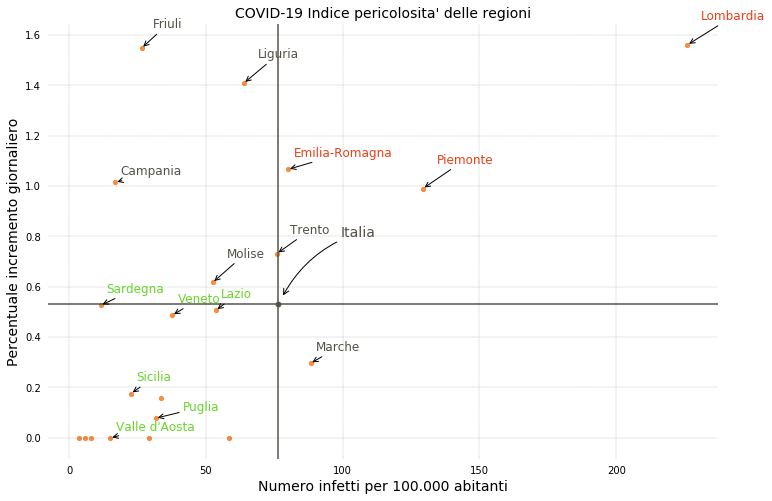

In [93]:
#-------------------------------------------------
#
#-------------------------------------------------

gray   = "#545146"
green  = "#69d52b"
red    = "#ea4118"
orange = "#f68d3f"

fig = plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(1, 1
                       ,hspace=0.2
                       ,wspace=0.1 
                       ,figure=fig)

ax = []
ax.append(fig.add_subplot(gs1[0,0]))

x = merged["Infected_4_100k"]
y = merged["IncreasePercentage"]
reg_names = merged["Regione"]

it_infected4100k = merged["Totale attualmente positivi"].sum() / (popolazione_it/100000)
it_avg_percentage = merged["IncreasePercentage"].mean()
idx = 0
ax[idx].scatter(x, y, color=orange, s=70, marker=".")
ax[idx].axvline(it_infected4100k, color=gray)
ax[idx].axhline(it_avg_percentage, color=gray)
ax[idx].annotate("Italia", (it_infected4100k * 1.02, it_avg_percentage * 1.05), color=gray
                ,xytext = (it_infected4100k * 1.3, it_avg_percentage * 1.5)
                ,arrowprops = dict(facecolor = gray, arrowstyle="->", connectionstyle="arc3,rad=.2")
                ,fontsize=14)
ax[idx].scatter(it_infected4100k, it_avg_percentage, color = gray, s=90, marker=".")

for cx, cy, cn in zip(x, y, reg_names):
    if region_point_map.get(cn) is not None:
        x_diff = region_point_map[cn]["x_add"]
        y_diff = region_point_map[cn]["y_add"]
        txt = cn if region_point_map[cn].get("txt") is None else region_point_map[cn].get("txt")
        
        if cx <= it_infected4100k and cy <= it_avg_percentage:
            name_color = green
        elif cx > it_infected4100k and cy > it_avg_percentage:
            name_color = red
        elif cx <= it_infected4100k and cy > it_avg_percentage:
            name_color = gray
        elif cx < it_infected4100k and cy >= it_avg_percentage:    
            name_color = gray
        else:
            name_color = gray
        ax[idx].annotate(txt, (cx, cy), color=name_color
                    ,xytext = (cx + x_diff, cy + y_diff)
                    ,arrowprops = dict(facecolor = name_color, arrowstyle="->")
                    ,fontsize=12)

set_axes_common_properties(ax[idx], no_grid=False)

ax[idx].set_title("COVID-19 Indice pericolosita' delle regioni", fontsize=14)
ax[idx].set_xlabel("Numero infetti per 100.000 abitanti", fontsize=14)
ax[idx].set_ylabel("Percentuale incremento giornaliero", fontsize=14)

remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])


plt.savefig(os.path.join(images_path,"{prefix}RegionRanking.png".format(prefix=image_prefix))
           ,bbox_inches = 'tight'
           ,pad_inches = 0.2)


In [13]:
for cx, cy, cn in zip(x, y, reg_names):
    print((cx, cy, cn))

(58.54640677131013, 0.0, 'Abruzzo')
(5.818894833174049, 0.0, 'Basilicata')
(29.18048318332544, 0.0, 'Bolzano-Bozen')
(8.125980292197985, 0.0, 'Calabria')
(16.921635323313073, 1.0141987829614605, 'Campania')
(80.04259955186025, 1.0662177328843996, 'Emilia-Romagna')
(26.543879992077926, 1.5479876160990713, 'Friuli-Venezia Giulia')
(53.64023529798821, 0.5058488776478027, 'Lazio')
(63.84149838694242, 1.4084507042253522, 'Liguria')
(226.01053101663987, 1.5606401269673325, 'Lombardia')
(88.26488343747327, 0.2958579881656805, 'Marche')
(52.51334714239869, 0.6172839506172839, 'Molise')
(129.30014979895404, 0.9897490279250619, 'Piemonte')
(31.69276935519171, 0.0779423226812159, 'Puglia')
(11.527895079166301, 0.5263157894736842, 'Sardegna')
(22.617913029051785, 0.1759014951627089, 'Sicilia')
(33.583375613599046, 0.1593625498007968, 'Toscana')
(75.94027019918578, 0.7317073170731708, 'Trento')
(3.504250316512932, 0.0, 'Umbria')
(15.055228918717612, 0.0, "Valle d'Aosta-Vallée d'Aoste")
(37.70605266